# 데이터 사이언티스트 들을 위한 경진대회 캐글(Kaggle)
```text
-- 케글 코리아와 함께하는 2nd ML 대회 - House Price Prediction --
연습용 링크 : https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

제공받는 파일들
- train.csv; 모델 학습용 파일
- test.csv; 테스트용 파일
- sample_submissions.csv; 제출용 파일
```

# 여기서 예측해야 하는 컬럼은 price; 집의 가격
# 커널 소개; Baseline
#   link : https://www.kaggle.com/code/kcs93023/2019-ml-month-2nd-baseline/notebook

## Jupyter 초기화 방법 : https://gils-lab.tistory.com/11

# 3-4 일단 제출하고 시작해! Baseline 모델(1) Baseline 셋팅하기
# 필요한 라이브러리 세팅하기; LMS의 경우 이미 처리되어있음
```shell
    conda install -c conda-forge xgboost=1.4.2
    conda install -c conda-forge lightgbm=3.3.0
    conda install -c conda-forge missingno=0.5.0
```

In [3]:
# 시각화 그래프 준비
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# 필요한 라이브러리 임포트 하기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


In [5]:
# 로컬 기준 테스트 환경 구성
data_dir = '../data/kaggles/kakr_housing/'
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

../data/kaggles/kakr_housing/train.csv
../data/kaggles/kakr_housing/test.csv


```text 
Baseline 데이터 항목 목록
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트
```

In [6]:
# 데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [7]:
# 학습 데이터에서 라벨 제거하기
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
# 학습 데이터와 테스트 데이터 합치기
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))
data.head()

21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


```text
결측치가 없다면 까만색 bar-graph가 나온다. (full-filled)

데이터 프레임 고급 인덱싱 관련 [참고링크] (https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1)
```

In [10]:
# 직접 결측치 확인해보기
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [11]:
# 직접 결측치 확인해보기
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()


Series([], Name: id, dtype: int64)

In [12]:
# 직접 결측치 확인해보기
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [13]:
# 1 ~ 3과정을 한번에 표현한 예시
# 한 번에 뿅!
# 추가 : 위에 실행했던 코드는 f-string으로 작동하지만 해당 코드는 대괄호가 2개가 있어 f-string으로 표현하면 에러가 발생합니다. 이럴 경우 format으로 실행합니다.
# 추가에 대한 내용 : https://blockdmask.tistory.com/429
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [14]:
# 모든 컬럼에 대해서 null값에 대한 전처리를 해야하므로 for문 사용하여 조치
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [15]:
# id 컬럼 제거하기; 예측 결과 제출 시를 대비하여 sub_id 변수에 id 컬럼을 저장해둠
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [16]:
# date 컬럼을 apply 함수로 필요한 부분만 잘라쓰기
# 참고링크: https://data-newbie.tistory.com/207
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


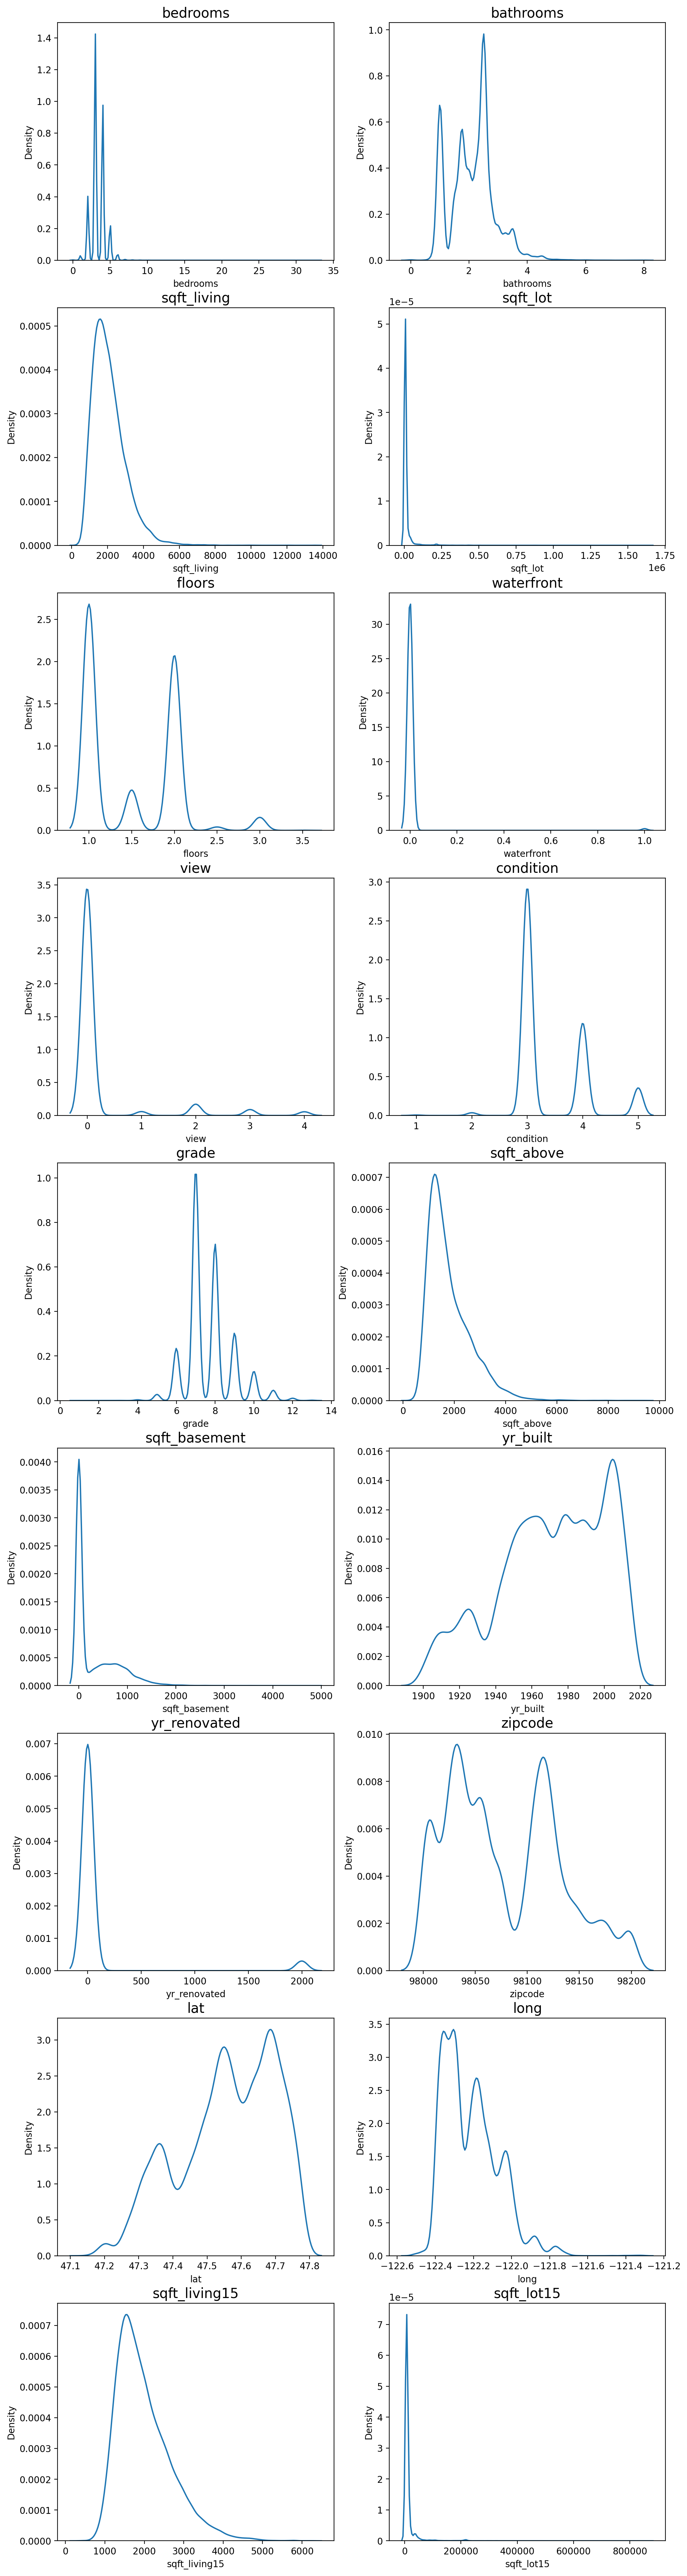

In [17]:
# 각 컬럼들의 데이터 분포 확인
# sns.kdeplot() 사용; 이산(discrete) 데이터도 부드러운 곡선으로 표현해줌

# 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [18]:
# 한쪽으로 치우친 컬럼들 (bedroons, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15)
# 로그변환하여 데이터 분포를 정규분포에 가깝게 만들기

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


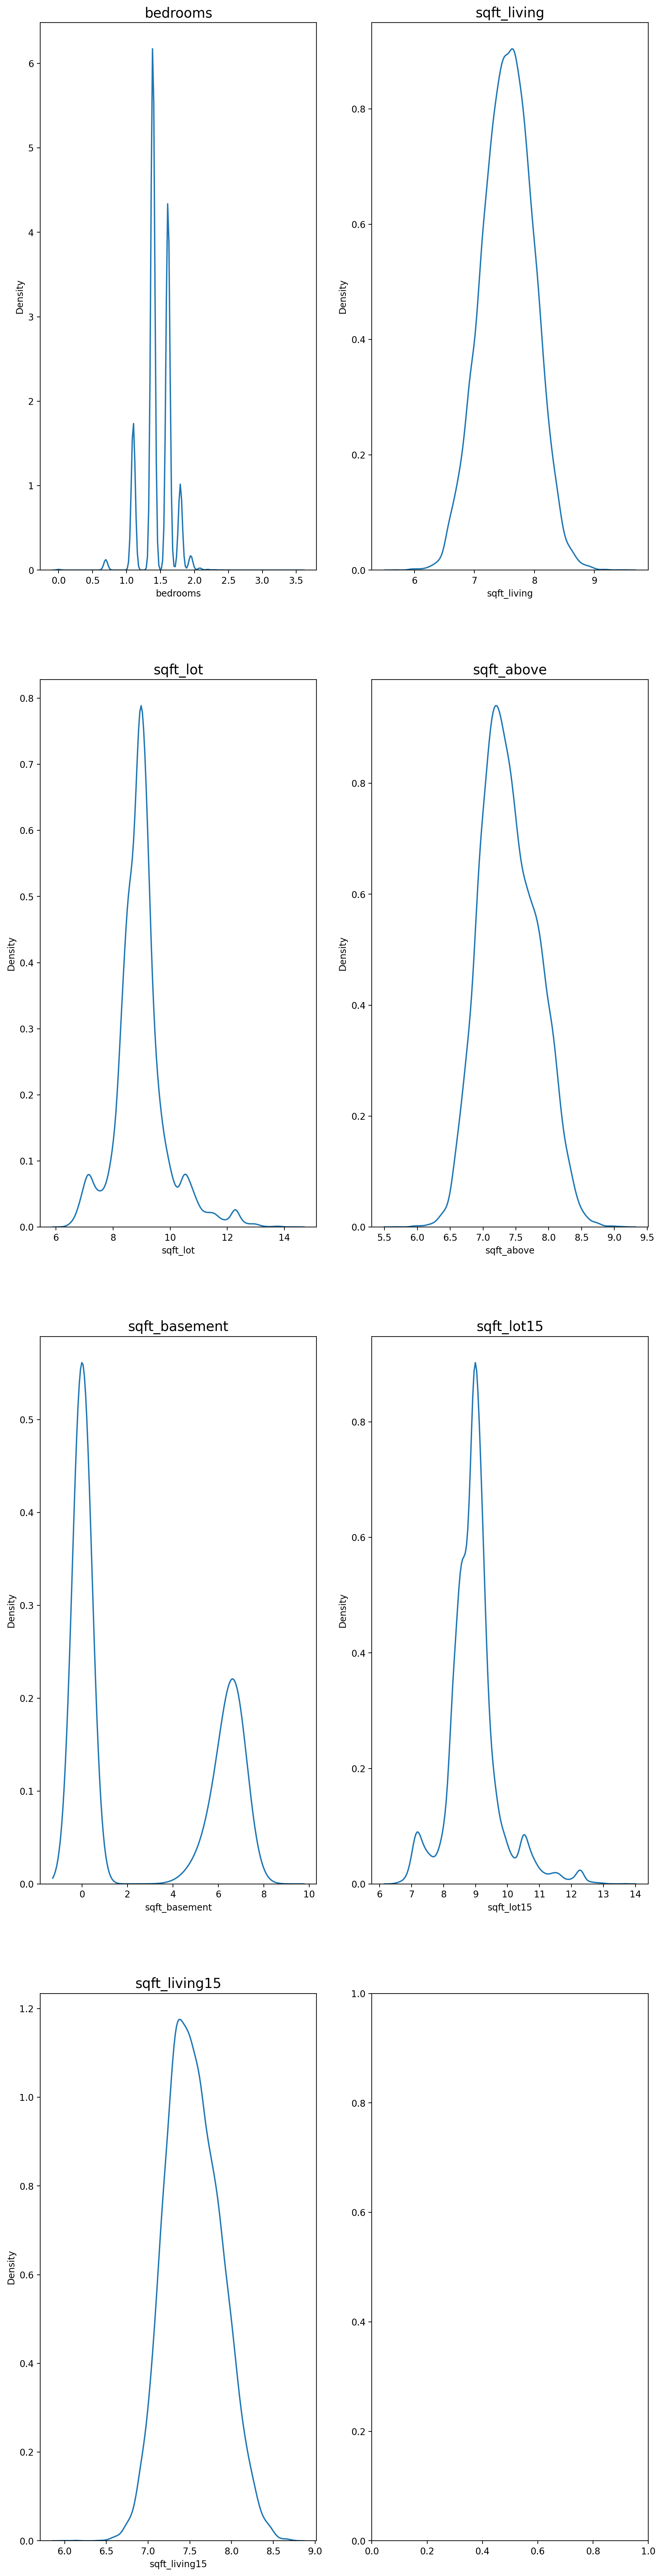

In [19]:
# 로그 변환을 한 컬럼들만 시각화하는 코드
# [[YOUR CODE]]
fig, ax = plt.subplots(4, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# skew_column의 모든 분포를 확인합니다.
count = 0

columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 7 :
            break

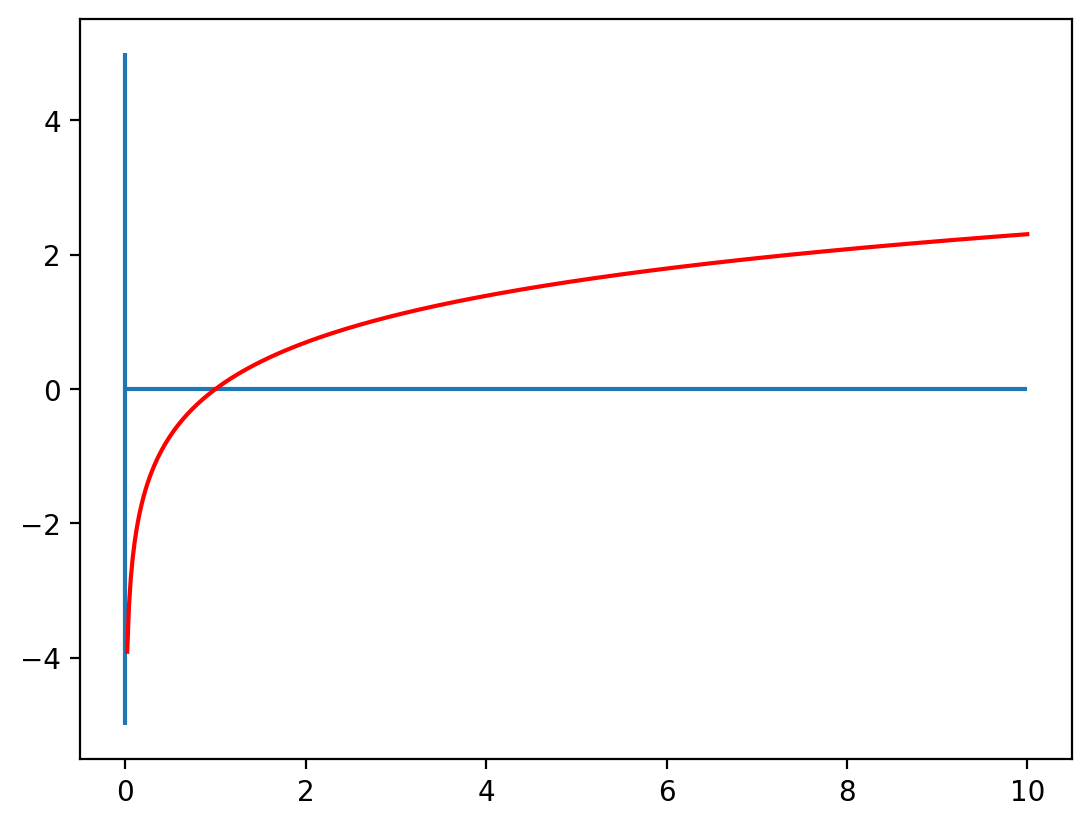

In [20]:
# 일반적인 로그 함수 예시
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

In [ ]:
"""
위와 같은 로그 함수의 특징
1. 0 < x < 1 범위에서는 기울기가 매우 가파르다.
    >> x의 구간은 (0, 1), y의 구간은 (-∞,0)
2. x 값이 0에 가까울수록 y의 값들은 매우 큰 범위로 벌어지게 된다.
    >> 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특성이 있다.
3. x 값이 커질수록 로그 함수의 기울기는 급격히 작아진다.
    >> 큰 x 값들에 대해서는 y값이 크게 차이나지 않게 된다.
    >> 넓은 범위를 가지는 x를 비교적 작은 y 갓의 구간 내에 모이게 하는 특징을 가진다.
"""

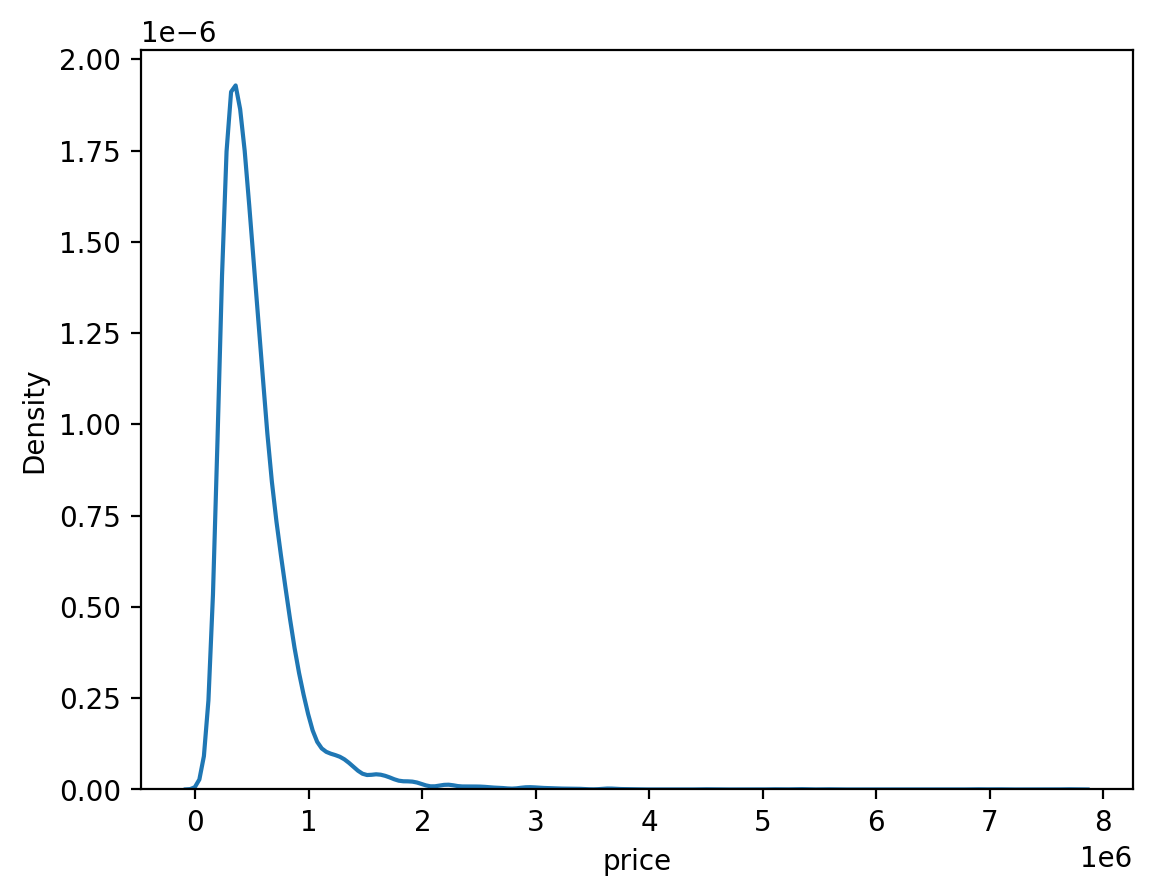

In [21]:
# 기존 df['price']의 분포
sns.kdeplot(y)
plt.show()

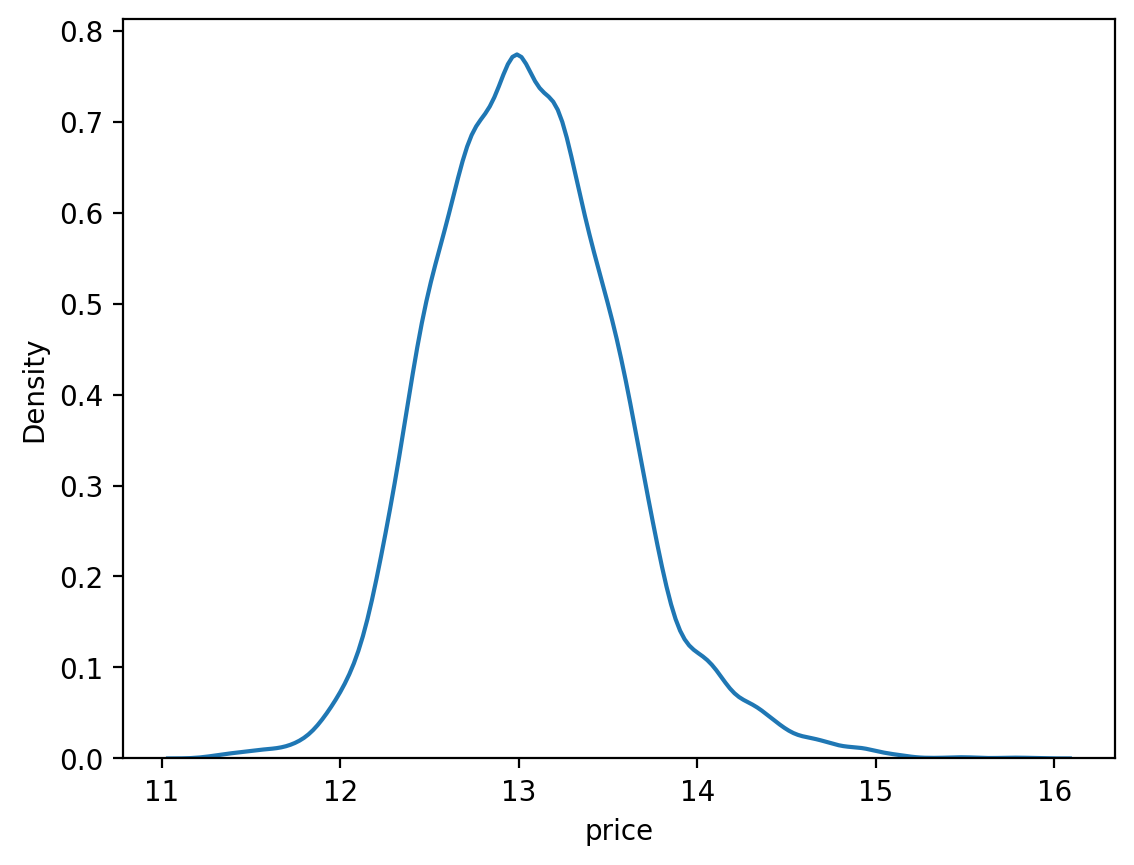

In [22]:
# df['price']의 로그 분포
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [23]:
# 기존 train_len를 활용하여 데이터를 학습 데이터(x), 추론 데이터(sub)에 저장하기
print(f"train_len: {train_len}")
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

train_len: 15035
(15035, 19)
(6468, 19)


# 모델링
```text
Baseline 커널에서는 여러 가지 모델을 함께 사용해 결과를 섞는, 블렌딩(blending) 기법을 활용함
블렌딩은 하나의 개별 모델을 사용하지 않고 여러 다양한 모델을 종합하여 사용한 후 결과를 얻는 기법
블렌딩은 앙상블 기법으로도 불린다.

참고링크: https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.

Kaggle ensemble guide: https://jamm-notnull.tistory.com/16
```

# 예시 기반 블렌딩 기법 이점 확인하기
```text
Q. 각각 성능이 70%(0.7)인 다섯 개의 분류기가 있다고 가정합니다.
이 때 이 다섯 개의 모델이 예측한 결과에 다수결 투표를 진행하여 최종 결과를 결정한다면 예상 정확도는 얼마일까요?
(힌트: 고등학생 때 배웠던 순열과 조합의 독립시행의 확률을 떠올려보세요!)

1. 전부 틀릴 확률: 0.3^5
2. 하나만 맞고 4개 틀릴 확률 = 5C1 x 0.3^4 x 0.7^1
3. 두 개 맞고 3개 틀릴 확률 = 5C2 x 0.3^3 x 0.7^2
4. 세 개 맞고 2개 틀릴 확률 = 5C3 x 0.3^2 x 0.7^3
5. 네 개 맞고 1개 틀릴 확률 = 5C4 x 0.3^1 x 0.7^4
6. 다섯 개 모두 맞을 확률 = 0.7^5


확인 : 위의 여섯가지의 확률의 총합은 0.0024 + 0.0284 + 0.1323 + 0.3087 + 0.3602 + 0.1681 = 1 이 맞습니다!)

위의 여섯 가지 중, 다수결을 통해 최종 예측을 결정을 할 때 옳은 예측을 하려면 최소 세 개 이상의 분류기가 맞아야 합니다.

즉, 세 개 이상의 분류기가 맞을 확률의 총 합은 0.3087 + 0.3602 + 0.1681 =0.837, 즉 83.7%입니다.

이는 개별 분류기의 성능인 70%보다 훨씬 높은 성능을 보입니다!
```

In [24]:
# 회귀 문제를 예측 결과 평균(Average Blending)으로 접근하여 푸는 방법 예시
# 부스팅 계열 모델 (gboost, xgboost, lightgbm)을 사용

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [25]:
# 교차 검증(Cross validation)을 통한 모델 성능 평가 기본
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')
# 부스팅 계열 모델 테스트 3가지에 대한 스코어 값 계산됨
get_cv_score(models)

얍💢
Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


```text
cross_val_score()는 회귀모델을 전달할 경우 R^2 점수를 반환; 해당 값은 1에 가까울 수록 모델이 잘 학습되었다는 것을 나타매

참고링크: https://ltlkodae.tistory.com/19
```

In [26]:
# 제출용 파일(submission file) 만들기
## Baseline 모델에서는 여러 모델이 입력될 때, 각 모델에 대한 예측 결과를 평균 내어 주는 AveragingBlending() 함수를 만들어 사용함
### AveragingBlending()은 모든 입력 모델들을 x와 y로 학습시킨 뒤 predictions에 예측 결과값을 모은다.
### 이후 이 값들을 모아 평균을 구하고 해당 평균값을 반환한다.
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [27]:
## 에측값 y_pred를 AveragingBlending()을 통해 획득
### 맥북(Intel)에서 수행 시 CPU 연산에 걸린거 같다. 엄청 느림..
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

In [ ]:
# 예측값(y_pred) 획득하면 kaggle에 제출하기 위해 csv 파일을 만들어야한다.
# 노드 기준 예시
# data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
data_dir = '../data/kaggles/kakr_housing'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
# id와 price로 구성된 데이터 프레임 만들기
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

In [ ]:
# submission.csv 파일로 저장하기
# 노드기준 예시경로
# my_submission_path = '/aiffel/aiffel/kaggle_kakr_housing/data'
# [[YOUR CODE]]
my_submission_path = '../data/kaggles/kakr_housing'
my_submission_file = 'submission.csv'
file_path = os.path.join(my_submission_path, my_submission_file)
result.to_csv(file_path)

print(file_path)

In [ ]:
# 내 입맛대로 데이터 준비하기
# 노드 예시
# data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
data_dir = '../data/kaggles/kakr_housing'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

# 데이터 확인
train.head()

In [ ]:
# datetime 컬럼의 값들을 6자리 정수로 변환하고 데이터 확인
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

In [ ]:
# 학습데이터(train)에서 가격('price')를 빼기 위해 작업; 컬럼 삭제
# 가격은 변수 y에 저장함
y = train['price']
del train['price']

print(train.columns)

In [ ]:
# 학습데이터(train)에서 id를 삭제하고 컬럼 확인
del train['id']

print(train.columns)

In [ ]:
# test 데이터에서 데이터 전처리
## price 컬럼은 없으니 처리 생략하기
# [[YOUR CODE]]
# 데이터 살펴보기
test.head()
# 테스트 데이터의 'date' 컬럼 정수형으로 변경
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head()

# price 컬럼 작업 생략

# id 컬럼 삭제 및 나머지 컬럼 확인
del test['id']

print(test.columns)

In [ ]:
# 타켓 데이터(y) 확인
y

In [ ]:
# 데이터 분포도를 시각화하여 확인
"""
seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인해주세요!
"""

#코드 작성
sns.kdeplot(y, shade=True)
plt.legend()
plt.show()

In [ ]:
# 좌편향 데이터를 로그 변환
y = np.log1p(y)
y

In [ ]:
# 로그화된 데이터 분포를 시각화
sns.kdeplot(y)
plt.show()

In [ ]:
"""
y는 np.log1p() 함수를 통해 로그 변환을 해주고, 
나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌리겠습니다. 
np.expm1()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해 줍니다.
"""
# 참고링크1: https://numpy.org/doc/stable/reference/generated/numpy.log1p.html
# 참고링크2: https://numpy.org/doc/stable/reference/generated/numpy.expm1.html

In [ ]:
# 전체 학습데이터 자료형 확인
train.info()

In [ ]:
# 훈련 데이터셋과 검증 데이터셋으로 나눌 train_test_split() 호출
# RMSE 계산을 위한 모듈 호출
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

In [ ]:
"""
대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위해 다음과 같은 함수를 만들어놓겠습니다.
한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 
원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점입니다.

exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있겠죠!
"""

# RMSE를 구하는 함수 선언
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

In [ ]:
# 네 가지 모델 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

In [ ]:
# 모델 인스턴스 생성 및 결집
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

In [ ]:
# 모델 이름 확인; __class__.__name__을 통해 가능
gboost.__class__.__name__

In [ ]:
# 모델 별 학습 및 예측
df = {}

# train.shape
# test.shape

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    # [[YOUR CODE]]
    x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

    # 모델 학습
    # [[YOUR CODE]]
    model.fit(x_train, y_train)
    
    # 예측
    # [[YOUR CODE]]
    y_pred = model.predict(x_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred) # [[YOUR CODE]]
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

In [ ]:
# 모델 별 학습 및 예측을 함수화
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        # [[YOUR CODE]]
        x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        # [[YOUR CODE]]
        model.fit(x_train, y_train)
        
        # 예측
        # [[YOUR CODE]]
        y_pred = model.predict(x_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred) # [[YOUR CODE]]
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return df

get_scores(models, train, y)

In [ ]:
# 다양한 하이퍼 파라미터 튜닝 테스트
## GridSearchCV 클래스 활용
from sklearn.model_selection import GridSearchCV

print('얍💢')

In [ ]:
"""
GridSearchCV에 입력되는 인자들

- pram_grid: 탐색할 파라미터의 종류 (type is dict)
- scoring: 모델의 성능을 평가할 지표
- cv: cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose: 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메시지의 양
    - 숫자가 클수록 더 많은 메시지를 출력함
- n_jobs: 그리드 탐색을 진행하면서 사용할 CPU의 개수
"""

In [ ]:
# xgboost 관련 하이퍼 파라미터 준비
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [ ]:
# 모델 준비; LightGBM(lgbm) 사용
model = LGBMRegressor(random_state=random_state)

print('얍💢')

In [ ]:
# grid_model 초기화 및 모델 학습
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

In [ ]:
# grid_model 실험 결과 확인
grid_model.cv_results_

In [ ]:
# 파라미터 조합 결과 확인
params = grid_model.cv_results_['params']

# 추가 확인
print("파라미터")
print(f"{params}")
print("타입")
print(f"{type(params)}")
print("길이")
print(f"{len(params)}")

In [ ]:
# 테스트 점수 결과 확인
score = grid_model.cv_results_['mean_test_score']
score

# 추가 확인
print("스코어")
print(f"{score}")
print("길이")
print(f"{len(score)}")

다음과 같은 형태의 데이터 프레임 출력하는 코드 작성해보기
<table>
    <tr>
        <td>max_depth</td>
        <td>n_estimators</td>
        <td>score</td>
    </tr>
    <tr>
        <td>1</td>
        <td>50</td>
        <td>-0.077518</td>
    </tr>
    <tr>
        <td>1</td>
        <td>100</td>
        <td>-0.054988</td>
    </tr>
    <tr>
        <td>10</td>
        <td>50</td>
        <td>-0.034190</td>
    </tr>
    <tr>
        <td>10</td>
        <td>100</td>
        <td>-0.027051</td>
    </tr>
</table>

In [ ]:
# 여기에 코드를 작성하세요.
new_one = []

for idx in range(len(params)):
    temp_dict = dict()
    temp_dict = params[idx]
    temp_dict['score'] = score[idx]
    new_one.append(temp_dict)

# print(f"{new_one}")
results = pd.DataFrame(new_one)

print(results)

In [ ]:
## 예시 코드 (with pandas)
# results = pd.DataFrame(params)
# results['score'] = score

# results

In [ ]:
# RMSE 점수로 확인
## 기존 Regression에서는 neg_mean_squeared_error가 사용되어 score 값이 음수로 표현되는 것임
results['RMSE'] = np.sqrt(-1 * results['score'])
results

In [ ]:
# RMSE 컬럼명을 RMSLE로 변경
## why? 기존 데이터가 좌편향되어서 log처리를 해주었기 때문
results = results.rename(columns={'RMSE': 'RMSLE'})
results

In [ ]:
# sort_values()를 사용하여 RMSLE가 낮은 순서대로 정렬하기
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬해주세요.
results.sort_values(by=['RMSLE'])

In [ ]:
# 예시 코드
# results = results.sort_values('RMSLE')
# results

# Gridsearch 과정을 함수로 구현
```text
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
```

In [ ]:
# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
# my_GridSearch()로 그리드 탐색하여 성능 확인
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

In [ ]:
# 가장 좋은 조합인 max_depth=10, n_estimators=100
# 가지고 모델 학습 수행
# 이후 예측값을 submission.csv 파일로 생성 후 kaggle에 제출
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

In [ ]:
## 로그변환값(RMSLE)을 원래 스케일로 되돌리기
prediction = np.expm1(prediction)
prediction

In [ ]:
# sample_submission.csv 파일 가져오기
# 노드 예시 경로
# data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
data_dir = '../data/kaggles/kakr_housing'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
# sample dataframe의 price에 예측값 덮어씌우기
# kaggle 제출용 데이터 만들어짐
submission['price'] = prediction
submission.head()

In [ ]:
# 위 데이터를 CSV 파일로 저장
# 모델 종류와 예측값(RMSLE)을 파일에 명시
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

In [ ]:
# 모델을 학습시켜 예측값을 CSV로 파일로 만드는 과정을 하나의 함수로 구현
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))